In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import roc_auc_score
import scipy
import os
from sklearn import mixture
from scipy.stats import norm


## Look at the spreadsheets that Emily sent

Let's start with the PET spreadsheet

In [317]:
df_tau = pd.read_csv('input/tau_anchord_ASHST1.csv', low_memory=False)
df_tau.head()

,RID,ID,ICV,Slice_Thickness,left_CA1_vol,left_CA1_ns,left_CA1_tau,left_CA1_amy,left_CA2_vol,left_CA2_ns,...,EXAMDATE_MMSCORE,MMSCORE,EXAMDATE_COG,LDELTOTAL_VALIDATE,ImputedDX,YearsToConversion,YearsOfAvailFollowup,ImputedAMYLOID,DX2,END
0,5242,019_S_5242,0 0.00,0,0,0,0,0,0,0,...,NaN,29.0,NaN,15.0,False,NaN,0.000000,False,1.0,-1
1,5269,135_S_5269,01383910.00,0,0,0,0,0,0,0,...,NaN,27.0,NaN,10.0,False,NaN,0.000000,False,1.0,-1
2,5273,135_S_5273,01268580.00,0,0,0,0,0,0,0,...,NaN,27.0,NaN,10.0,False,NaN,0.999316,False,4.0,-1
3,4815,137_S_4815,01232340.00,0,0,0,0,0,0,0,...,NaN,24.0,NaN,0.0,False,NaN,2.061602,False,3.0,-1
4,800,137_S_0800,01285680.00,0,0,0,0,0,0,0,...,NaN,24.0,NaN,3.0,False,NaN,0.000000,False,5.0,-1


In [318]:
r = re.compile('.*suvr.*')
df_tau[[x for x in df_tau.columns if r.match(x.lower())]].head()
[x for x in df_tau.columns if r.match(x.lower())]

['SUMMARYSUVR_WHOLECEREBNORM_AV45',
 'SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF_AV45',
 'SUMMARYSUVR_COMPOSITE_REFNORM_AV45',
 'SUMMARYSUVR_COMPOSITE_REFNORM_0.78CUTOFF_AV45',
 'SUMMARYSUVR_WHOLECEREBNORM_FBB',
 'SUMMARYSUVR_WHOLECEREBNORM_1.08CUTOFF_FBB',
 'SUMMARYSUVR_COMPOSITE_REFNORM_FBB',
 'SUMMARYSUVR_COMPOSITE_REFNORM_0.74CUTOFF_FBB',
 'SUMMARYSUVR_WHOLECEREBNORM_CUTOFF_AV45FBB']

In [319]:
df_tau[['SMARTDATE.x','SMARTDATE.y','MRI_TAU_datediff']]

,SMARTDATE.x,SMARTDATE.y,MRI_TAU_datediff
0,2015-08-26T04:00:00Z,2015-08-12T04:00:00Z,-14
1,2015-09-02T04:00:00Z,2015-09-02T04:00:00Z,0
2,2015-09-03T04:00:00Z,2015-08-26T04:00:00Z,-8
3,2015-09-30T04:00:00Z,2014-08-29T04:00:00Z,-397
4,2015-10-01T04:00:00Z,2016-09-15T04:00:00Z,350
...,...,...,...
1253,2021-06-29T04:00:00Z,2021-06-17T04:00:00Z,-12
1254,2021-07-06T04:00:00Z,2021-06-21T04:00:00Z,-15
1255,2021-07-07T04:00:00Z,2019-08-19T04:00:00Z,-688
1256,2021-07-09T04:00:00Z,2021-06-18T04:00:00Z,-21


### Define the Braak stage Tau cutoffs based on Jack (2023)

In [320]:
df_braak_rois = pd.read_csv('input/tau_braak_rois.csv')
df_braak_rois.head()

,ROI,B1,B2,B3,Unsure
0,ACgG_anterior_cingulate_gyrus_tau,0,1,0,NaN
1,AIns_anterior_insula_tau,0,1,0,NaN
2,AOrG_anterior_orbital_gyrus_tau,0,0,1,NaN
3,Amygdala_tau,0,0,0,NaN
4,AnG_angular_gyrus_tau,0,0,1,NaN


In [327]:
cols_b1 = []
for key in df_braak_rois.query('B1==1').ROI:
    cols_b1.append('Left_' + key)
    cols_b1.append('Right_' + key)
df_tau['jack_b1_suvr'] = df_tau[cols_b1].mean(axis=1)
# df_tau['jack_b1_status'] = df_tau.jack_b1_suvr >= 1.28
df_tau['jack_b1_status'] = df_tau.jack_b1_suvr >= 1.23

cols_b2 = []
for key in df_braak_rois.query('B2==1').ROI:
    cols_b2.append('Left_' + key)
    cols_b2.append('Right_' + key)
df_tau['jack_b2_suvr'] = df_tau[cols_b2].mean(axis=1)
df_tau['jack_b2_status'] = df_tau.jack_b2_suvr >= 1.33

cols_b3 = []
for key in df_braak_rois.query('B3==1').ROI:
    cols_b3.append('Left_' + key)
    cols_b3.append('Right_' + key)
df_tau['jack_b3_suvr'] = df_tau[cols_b3].mean(axis=1)
df_tau['jack_b3_status'] = df_tau.jack_b3_suvr >= 1.30

df_tau[['jack_b1_suvr','jack_b2_suvr','jack_b3_suvr']]

,jack_b1_suvr,jack_b2_suvr,jack_b3_suvr
0,0.962545,1.001273,0.928471
1,1.028343,1.076986,1.015286
2,1.111352,1.064893,1.009860
3,1.538005,1.272989,1.184185
4,1.574095,1.330191,1.176397
...,...,...,...
1253,1.023576,1.085486,1.086208
1254,1.012117,1.052677,1.035245
1255,1.068502,0.980861,0.890482
1256,1.131115,1.076107,1.061153


(array([ 1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  2.,  1.,  0.,  0.,
         0.,  1.,  1.,  1.,  0.,  2.,  5.,  4.,  4.,  3.,  2.,  1.,  2.,
         4.,  6.,  7.,  4.,  2.,  3.,  3., 10.,  7.,  5.,  5.,  7.,  3.,
        11.,  8.,  9.,  4.,  6., 10.,  8.,  6.,  8., 11., 10.,  7., 15.,
         8., 16.,  9., 15., 16., 22., 15., 11., 15., 10., 18., 16., 14.,
        22., 13., 16., 17., 11., 16., 27., 20., 21., 10., 11., 18., 15.,
        11., 13., 11., 12., 11., 14., 15.,  5.,  8.,  9., 12.,  9.,  8.,
        11.,  8., 11.,  6.,  4.,  5.,  9.,  3.,  6.,  3., 10.,  7.,  9.,
         5.,  8.,  2.,  7.,  7.,  8.,  7.,  9.,  4.,  8.,  7.,  2.,  3.,
         4.,  0.,  4.,  4.,  6.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  4.,
         6.,  1.,  2.,  5.,  1.,  2.,  4.,  0.,  4.,  0.,  1.,  3.,  3.,
         3.,  1.,  2.,  3.,  1.,  4.,  2.,  1.,  4.,  3.,  1.,  1.,  5.,
         1.,  0.,  3.,  2.,  1.,  4.,  3.,  4.,  5.,  2.,  2.,  6.,  2.,
         1.,  3.,  1.,  1.,  0.,  1.,  0.,  4.,  2.

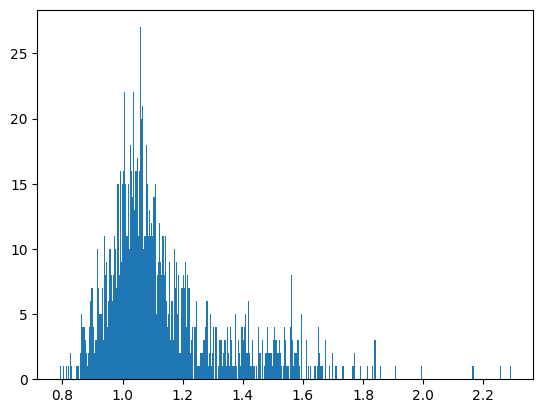

In [359]:
x = np.array(df_tau.query('jack_b1_suvr > 0.1')['jack_b1_suvr'])
plt.hist(x,400)

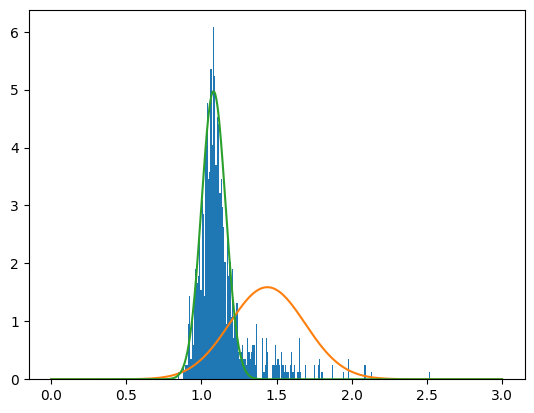

In [373]:
x = np.array(df_tau.query('jack_b1_suvr > 0.1')['jack_b2_suvr'].sample(1000, replace=True))


t = np.linspace(0,3,1000)
clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
clf.fit(x.reshape(-1, 1))
clf
pdfs = clf.predict_proba(t.reshape(-1,1))
plt.hist(x, 200, density=True);
plt.plot(t, norm(clf.means_[0], np.sqrt(clf.covariances_[0,0])).pdf(t))
plt.plot(t, norm(clf.means_[1], np.sqrt(clf.covariances_[1,0])).pdf(t))
#plt.plot(norm(clf.means_[0], clf.covariances_[0]).pdf(t))

#plt.plot(t, pdfs[:,0], label='p(Component 1)');
#plt.plot(t, pdfs[:,1], label='p(Component 2)');
#plt.legend();

Report the number of cases where the progression is typical, i.e., later Braak stages do not exceed earlier stages

In [322]:
df_tau['jack_bstage'] = np.nan
df_tau.loc[(df_tau.jack_b1_status==False) & (df_tau.jack_b2_status==False) & (df_tau.jack_b3_status==False), 'jack_bstage'] = 0
df_tau.loc[(df_tau.jack_b1_status==True) & (df_tau.jack_b2_status==False) & (df_tau.jack_b3_status==False), 'jack_bstage'] = 1
df_tau.loc[(df_tau.jack_b1_status==True) & (df_tau.jack_b2_status==True) & (df_tau.jack_b3_status==False), 'jack_bstage'] = 2
df_tau.loc[(df_tau.jack_b1_status==True) & (df_tau.jack_b2_status==True) & (df_tau.jack_b3_status==True), 'jack_bstage'] = 3

In [323]:
df_tau.groupby('jack_bstage', dropna=False).size().reset_index(name='size')

,jack_bstage,size
0,0.0,972
1,1.0,170
2,2.0,35
3,3.0,65
4,NaN,16


Maybe we can combine B2 and B3 regions into one, and instead look at their combined severity.

In [324]:
cols_b23 = []
for key in df_braak_rois.query('B2==1 or B3==1').ROI:
    cols_b23.append('Left_' + key)
    cols_b23.append('Right_' + key)
df_tau['jack_b23_suvr'] = df_tau[cols_b23].mean(axis=1)
df_tau['jack_b23_status'] = df_tau.jack_b23_suvr >= 1.315

In [325]:
df_tau['jack_b23stage'] = np.nan
df_tau.loc[(df_tau.jack_b1_status==False) & (df_tau.jack_b23_status==False), 'jack_b23stage'] = 0
df_tau.loc[(df_tau.jack_b1_status==True) & (df_tau.jack_b23_status==False), 'jack_b23stage'] = 1
df_tau.loc[(df_tau.jack_b1_status==True) & (df_tau.jack_b23_status==True), 'jack_b23stage'] = 2

In [326]:
df_tau.groupby('jack_b23stage', dropna=False).size().reset_index(name='size')

,jack_b23stage,size
0,0.0,975
1,1.0,196
2,2.0,75
3,NaN,12


## Try to operationalize cortical reference region cutoff

Look at the individuals that are B2 positive, and plot the distribution of their tau in the B2/B3 combined region

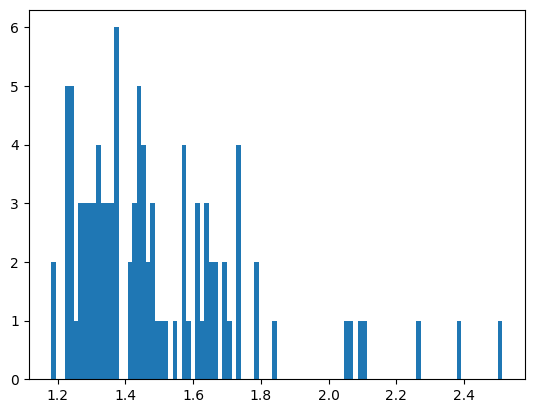

In [374]:
plt.hist(df_tau.query('jack_b1_status==True and jack_b2_status==True').jack_b23_suvr, 100);

In [280]:
data_gmm = np.array(df_tau.query('jack_b1_status==True and jack_b2_status==True').jack_b23_suvr)

In [281]:
from sklearn import mixture
clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
clf.fit(data_gmm.reshape(-1, 1))

GaussianMixture(n_components=2)

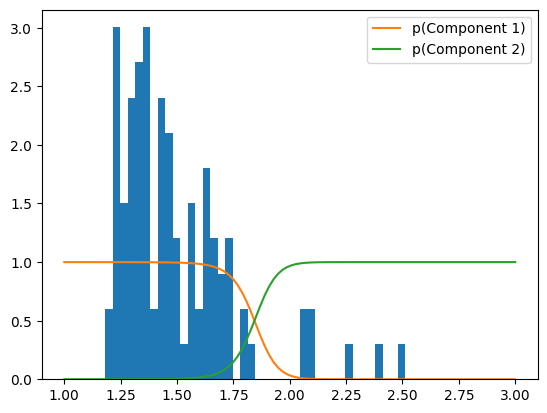

In [282]:
t = np.linspace(1,3,100)
pdfs = clf.predict_proba(t.reshape(-1,1))
plt.hist(df_tau.query('jack_b1_status==True and jack_b2_status==True').jack_b23_suvr, 40, density=True);
plt.plot(t, pdfs[:,0], label='p(Component 1)');
plt.plot(t, pdfs[:,1], label='p(Component 2)');
plt.legend();

In [283]:
# Just define a cutoff
cutoff_high = 1.5

In [284]:
df_tau['jack_t_sev'] = np.nan
df_tau.loc[(df_tau.jack_b1_status==False) & (df_tau.jack_b23_status==False), 'jack_t_sev'] = 0
df_tau.loc[(df_tau.jack_b1_status==True) & (df_tau.jack_b23_status==False), 'jack_t_sev'] = 1
df_tau.loc[(df_tau.jack_b1_status==True) & (df_tau.jack_b23_status==True) & (df_tau.jack_b23_suvr <= cutoff_high), 'jack_t_sev'] = 2
df_tau.loc[(df_tau.jack_b1_status==True) & (df_tau.jack_b23_status==True) & (df_tau.jack_b23_suvr > cutoff_high), 'jack_t_sev'] = 3

In [285]:
df_tau.groupby('jack_t_sev').size().reset_index(name='size')

,jack_t_sev,size
0,0.0,975
1,1.0,196
2,2.0,39
3,3.0,36


## Define biological categories based on Amyloid and Braak

In [286]:
# Create an a-beta status column
df_tau['ab_status'] = df_tau[['SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF_AV45', 'SUMMARYSUVR_WHOLECEREBNORM_1.08CUTOFF_FBB']].max(1)
df_tau['ab_status'] = df_tau['SUMMARYSUVR_WHOLECEREBNORM_CUTOFF_AV45FBB']
df_tau.groupby('ab_status', dropna=False).size().reset_index(name='size')

,ab_status,size
0,0.0,571
1,1.0,645
2,NaN,42


In [287]:
df_tau['jack_ab_stage'] = 'other'
df_tau.loc[(df_tau.ab_status == 0) & (df_tau.jack_bstage == 0),'jack_ab_stage'] = 'A-B0'
df_tau.loc[(df_tau.ab_status == 1) & (df_tau.jack_bstage == 0),'jack_ab_stage'] = 'A+B0'
df_tau.loc[(df_tau.ab_status == 1) & (df_tau.jack_bstage == 1),'jack_ab_stage'] = 'A+B1'
df_tau.loc[(df_tau.ab_status == 1) & (df_tau.jack_bstage == 2),'jack_ab_stage'] = 'A+B2'
df_tau.loc[(df_tau.ab_status == 1) & (df_tau.jack_bstage == 3),'jack_ab_stage'] = 'A+B3'

In [288]:
df_tau.groupby('jack_ab_stage', dropna=False).size().reset_index(name='size')

,jack_ab_stage,size
0,A+B0,376
1,A+B1,157
2,A+B2,33
3,A+B3,64
4,A-B0,557
5,other,71


In [289]:
df_tau.groupby(['ab_status','jack_bstage'], dropna=False).size().reset_index(name='size')

,ab_status,jack_bstage,size
0,0.0,0.0,557
1,0.0,1.0,12
2,0.0,2.0,1
3,0.0,3.0,1
4,1.0,0.0,376
5,1.0,1.0,157
6,1.0,2.0,33
7,1.0,3.0,64
8,1.0,NaN,15
9,NaN,0.0,39


In [290]:
df_tau['jack_at_stage'] = 'I'
df_tau.loc[(df_tau.ab_status == 0) & (df_tau.jack_t_sev == 0),'jack_at_stage'] = 'N'
df_tau.loc[(df_tau.ab_status == 1) & (df_tau.jack_t_sev == 0),'jack_at_stage'] = 'A'
df_tau.loc[(df_tau.ab_status == 1) & (df_tau.jack_t_sev == 1),'jack_at_stage'] = 'B'
df_tau.loc[(df_tau.ab_status == 1) & (df_tau.jack_t_sev == 2),'jack_at_stage'] = 'C'
df_tau.loc[(df_tau.ab_status == 1) & (df_tau.jack_t_sev == 3),'jack_at_stage'] = 'D'

In [291]:
def compute_jack_numbers(df):
    return df.groupby('jack_at_stage', dropna=False).size().reset_index(name='n_scans').merge(
        df.groupby('RID').head(1).groupby('jack_at_stage', dropna=False).size().reset_index(name='n_subj'))

In [292]:
compute_jack_numbers(df_tau)

,jack_at_stage,n_scans,n_subj
0,A,379,217
1,B,182,101
2,C,37,18
3,D,36,21
4,I,67,24
5,N,557,407


# Look at hippocampal subfields

In [293]:
# Load the data
df_sf = pd.read_csv('input/adni3_t2ashs_stats_qc_20231031.csv')

# Drop low QC cases
df_sf = df_sf.query('T2_QC_R >= 1 and T2_QC_L >= 1')

# Drop outlier
df_sf = df_sf[(df_sf.right_CA1_vol < 4000) & (df_sf.left_CA1_vol < 4000)]

In [294]:
# Export a manifest file for running CRASHS and thickness computation
df_sf[['ID','SMARTDATE','T2_QC_L','T2_QC_R']].to_csv('adni_crashs_manifest.csv', header=False, index=False)

In [295]:
# Load the thickness spreadsheet and merge with the volume one
df_thick = pd.read_csv('work/adni_crashs_thickness.csv')
df_sf = df_sf.merge(df_thick, on=['ID','SMARTDATE'], how='left')

In [296]:
df_tau_sub = df_tau.loc[(~df_tau['SMARTDATE.y'].isna()) & (np.abs(df_tau.MRI_TAU_datediff) < 366), ['ID','SMARTDATE.y','jack_ab_stage','jack_at_stage','ICV_ASHSICV','AGE']]
df_tau_sub['SMARTDATE'] = pd.to_datetime(df_tau_sub['SMARTDATE.y']).dt.strftime('%Y-%m-%d')
df_tau_sub = df_tau_sub[['ID','SMARTDATE','jack_ab_stage','jack_at_stage','ICV_ASHSICV','AGE']]
df_tau_sub

,ID,SMARTDATE,jack_ab_stage,jack_at_stage,ICV_ASHSICV,AGE
0,019_S_5242,2015-08-12,A-B0,N,1597428.650,67.2
1,135_S_5269,2015-09-02,A-B0,N,1488051.276,64.9
2,135_S_5273,2015-08-26,A+B0,A,1372477.636,90.1
4,137_S_0800,2016-09-15,A+B2,B,1436371.879,74.0
5,027_S_5277,2015-09-02,A+B0,A,1334631.648,71.8
...,...,...,...,...,...,...
1251,114_S_6251,2020-10-22,A+B1,B,1196714.000,65.5
1252,135_S_4723,2021-06-18,A-B0,N,1329656.000,69.4
1253,135_S_4722,2021-06-17,A-B0,N,1354247.000,68.0
1254,023_S_6702,2021-06-21,A+B0,A,1352491.000,64.4


In [297]:
df_test = df_sf.merge(df_tau_sub, how='left', on=['ID','SMARTDATE'])
df_test = df_test[~df_test.jack_ab_stage.isna()]
compute_jack_numbers(df_test)

,jack_at_stage,n_scans,n_subj
0,A,313,193
1,B,141,84
2,C,32,17
3,D,30,19
4,I,40,15
5,N,452,355


Extract a subset of cases to prioritize manual QC

In [298]:
# People on whom I was able to run CRASHS
df_for_qc = df_test.loc[~(df_test.left_crashs_qc95.isna() | df_test.right_crashs_qc95.isna())]
compute_jack_numbers(df_for_qc)

,jack_at_stage,n_scans,n_subj
0,A,283,178
1,B,116,70
2,C,20,9
3,D,28,20
4,I,30,10
5,N,407,329


In [299]:
def sample_stage(df, s, n):
    # All subjects with this stage
    x = df.loc[df.jack_at_stage == s]

    # Take best scan per subject
    x['worst_mri_qc'] = np.minimum(df.T2_QC_R, df.T2_QC_L)
    x['best_mri_qc'] = np.maximum(df.T2_QC_R, df.T2_QC_L)
    x = x.sort_values(['worst_mri_qc', 'best_mri_qc'], ascending=False)
    y = x.groupby('RID').head(1)

    # If there are more than n unique subjects, return them
    if len(y) >= n:
        return y.sample(n, replace=False, random_state=99)
    elif len(x) <= n:
        return x
    else:
        return pd.concat([y, x.groupby('RID').nth(1).sample(n = len(y), random_state=99)])

# Take at most 120 per category
df_for_ashs_qc = pd.concat([sample_stage(df_test, s, 120) for s in ['A','B','C','D','N','I']])

# How many images are we QC-ing per group?
compute_jack_numbers(df_for_ashs_qc)

/tmp/ipykernel_27580/3209647974.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['worst_mri_qc'] = np.minimum(df.T2_QC_R, df.T2_QC_L)
/tmp/ipykernel_27580/3209647974.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['best_mri_qc'] = np.maximum(df.T2_QC_R, df.T2_QC_L)


ValueError: Cannot take a larger sample than population when 'replace=False'

In [300]:
df_for_ashs_qc_export = df_for_ashs_qc.sample(len(df_for_ashs_qc), random_state=99)[['RID','SMARTDATE','IMAGEUID_T2','T2_QC_L','T2_QC_R']]
df_for_ashs_qc_export.to_csv('ashs_t2_adnipaper_qc_subset.csv')

In [301]:
mean_icv = df_test.ICV_ASHSICV.mean()
for subfield in 'CA1','CA2','CA3','DG','SUB','ERC','BA35','BA36','PHC':
    for side in 'left', 'right':
        df_test[f'{side}_{subfield}_nvol'] = mean_icv**(2/3) * df_test[f'{side}_{subfield}_vol'] / (df_test[f'{side}_{subfield}_ns'] * df_test.ICV_ASHSICV**(2/3))
        df_test[f'{side}_{subfield}_cvol'] = mean_icv * df_test[f'{side}_{subfield}_vol'] / (df_test.ICV_ASHSICV)
    df_test[f'mean_{subfield}_nvol'] = df_test[[f'left_{subfield}_nvol', f'right_{subfield}_nvol']].mean(axis=1)

for subfield in 'SUB','ERC','BA35','BA36','PHC':
    df_test[f'mean_{subfield}_thk'] = df_test[[f'left_{subfield}_thk', f'right_{subfield}_thk']].mean(axis=1)

Now we should get rid of repeat measurements per subject. However, since right now the CRASHS-T2 QC is all over the place, let's prioritize based on the QC score

In [302]:
df_test['worst_crashs_qc95'] = np.maximum(df_test.left_crashs_qc95, df_test.right_crashs_qc95)

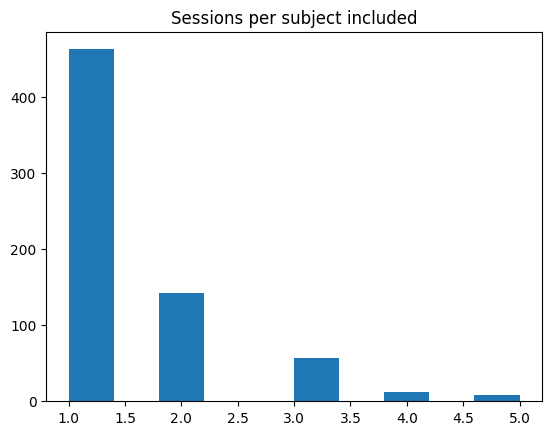

In [303]:
plt.hist(df_test.groupby('RID').size());
plt.title('Sessions per subject included');

In [304]:
df_test['worst_crashs_qc95'] = np.maximum(df_test.left_crashs_qc95, df_test.right_crashs_qc95)
df_persubj = df_test.sort_values(['worst_crashs_qc95', 'SMARTDATE'], ascending=[False, True]).groupby('RID').head(1)

In [305]:
df_persubj_cleanthk=df_persubj.query("worst_crashs_qc95 < 1.0")
df_persubj.groupby('jack_at_stage', dropna=False).size().reset_index(name='size')

,jack_at_stage,size
0,A,194
1,B,84
2,C,18
3,D,21
4,I,26
5,N,340


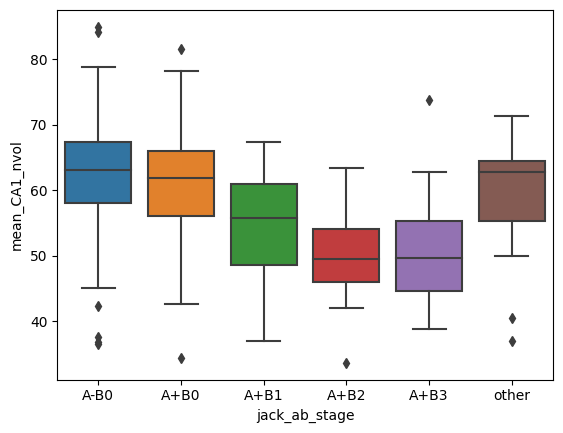

In [306]:
sns.boxplot(data=df_persubj_cleanthk, x='jack_ab_stage', y='mean_CA1_nvol', order=['A-B0','A+B0','A+B1','A+B2','A+B3','other']);

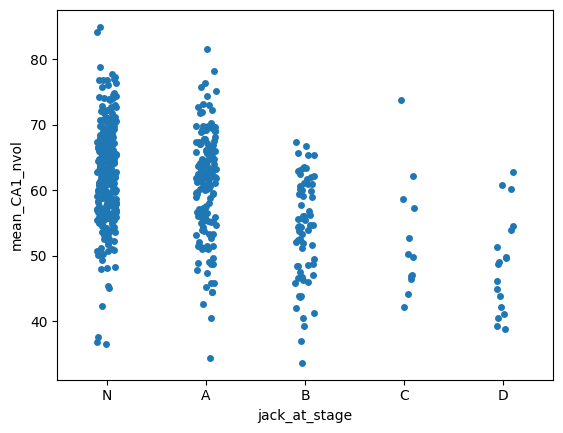

In [307]:
sns.stripplot(data=df_persubj_cleanthk, x='jack_at_stage', y='mean_CA1_nvol', order=['N','A','B','C','D']);

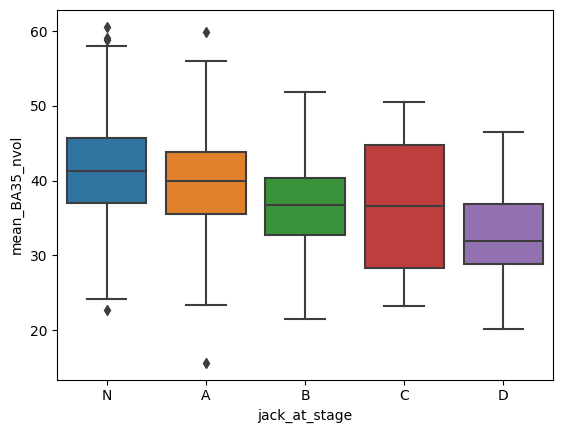

In [308]:
sns.boxplot(data=df_persubj_cleanthk, x='jack_at_stage', y='mean_BA35_nvol', order=['N','A','B','C','D']);

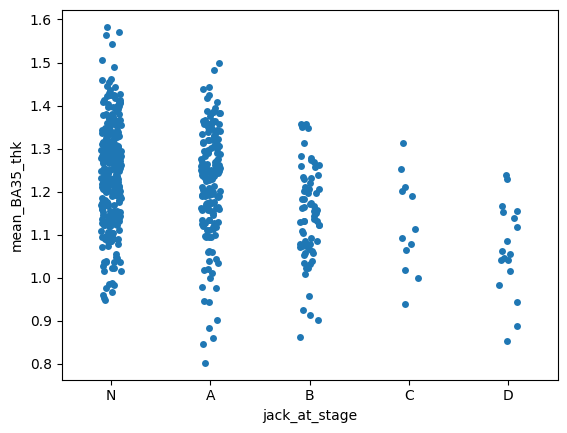

In [309]:
sns.stripplot(data=df_persubj_cleanthk, x='jack_at_stage', y='mean_BA35_thk', order=['N','A','B','C','D']);

In [310]:
from sklearn.metrics import roc_auc_score

In [311]:
r = re.compile('mean_.*_nvol')
all_nvol = sorted([c for c in df_persubj.columns if r.match(c)])

r = re.compile('mean_.*_thk')
all_thk = sorted([c for c in df_persubj.columns if r.match(c)])

all_meas = all_nvol + all_thk

In [312]:
# catlist = 'A-B0','A+B0','A+B1','A+B2','A+B3'
catlist = 'N','A','B','C','D'
catpairs = [ (-(i-j),i, c1,c2) for (i,c1) in enumerate(catlist)  for (j,c2) in enumerate(catlist) if i < j ]
catpairs = [ (c1, c2) for _,_,c1,c2 in sorted(catpairs)]

In [313]:
auctable = {}
mwu_table = {}
# auctable['subfield'] = all_nvol
for cat1, cat2 in catpairs:
    key = f'{cat1}-vs-{cat2}'
    auctable[key] = []
    mwu_table[key] = []
    for sf in all_meas:            
        sf_1 = df_persubj_cleanthk.loc[df_persubj_cleanthk.jack_at_stage == cat1, sf].dropna()
        sf_2 = df_persubj_cleanthk.loc[df_persubj_cleanthk.jack_at_stage == cat2, sf].dropna()
        auctable[key].append(roc_auc_score([1 for x in sf_1] + [0 for x in sf_2], pd.concat((sf_1, sf_2))))
        mwu_table[key].append(scipy.stats.mannwhitneyu(sf_1, sf_2, alternative='greater')[1])

df_auc = pd.DataFrame(auctable, index=all_meas)
df_mwu = pd.DataFrame(mwu_table, index=all_meas)

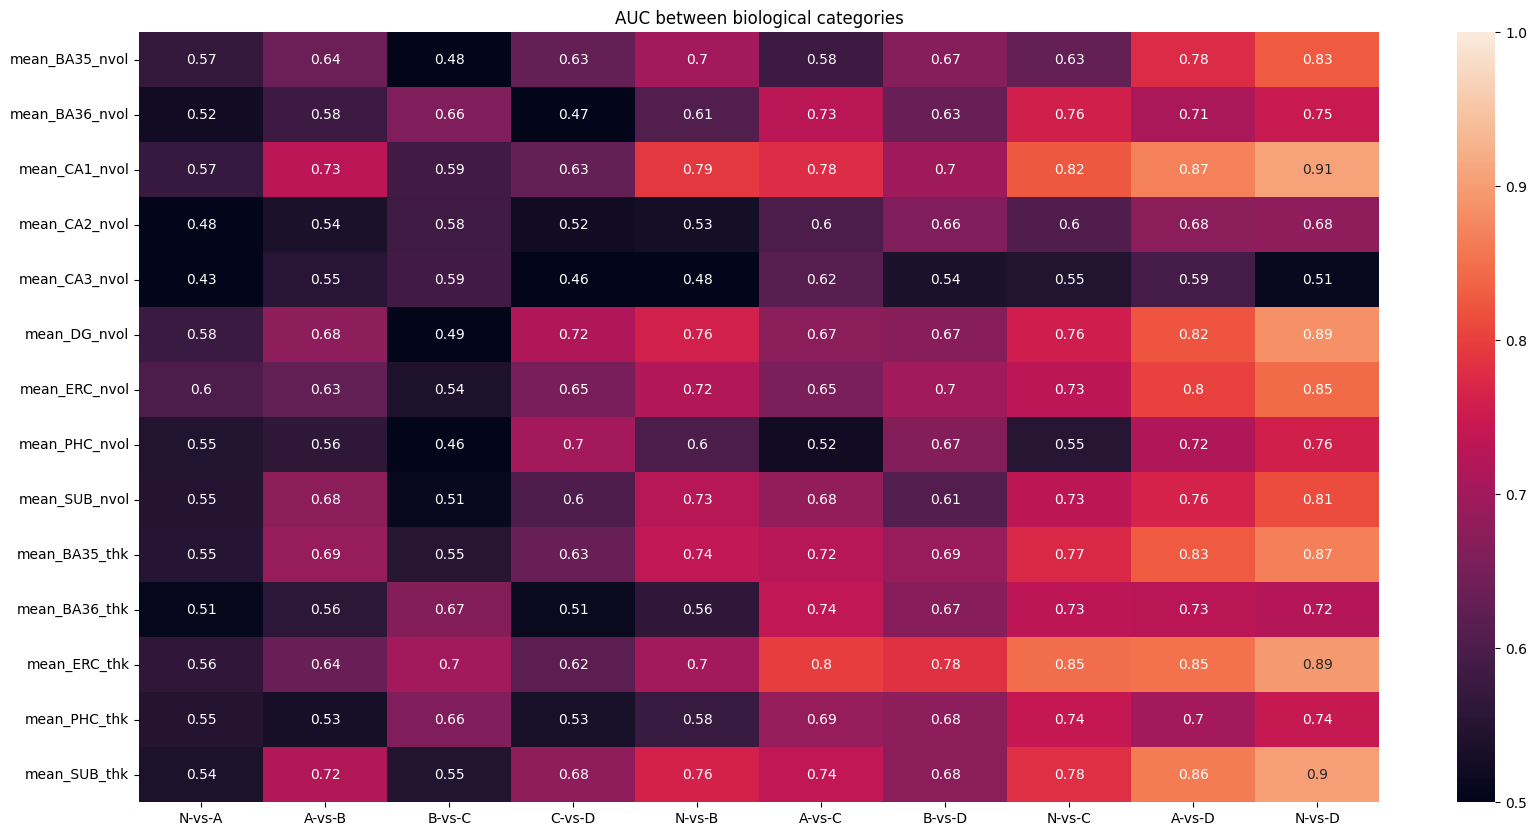

In [314]:
plt.figure(figsize=(20,10));
sns.heatmap(df_auc, annot=True, vmin=0.5, vmax=1.0);
plt.title('AUC between biological categories');

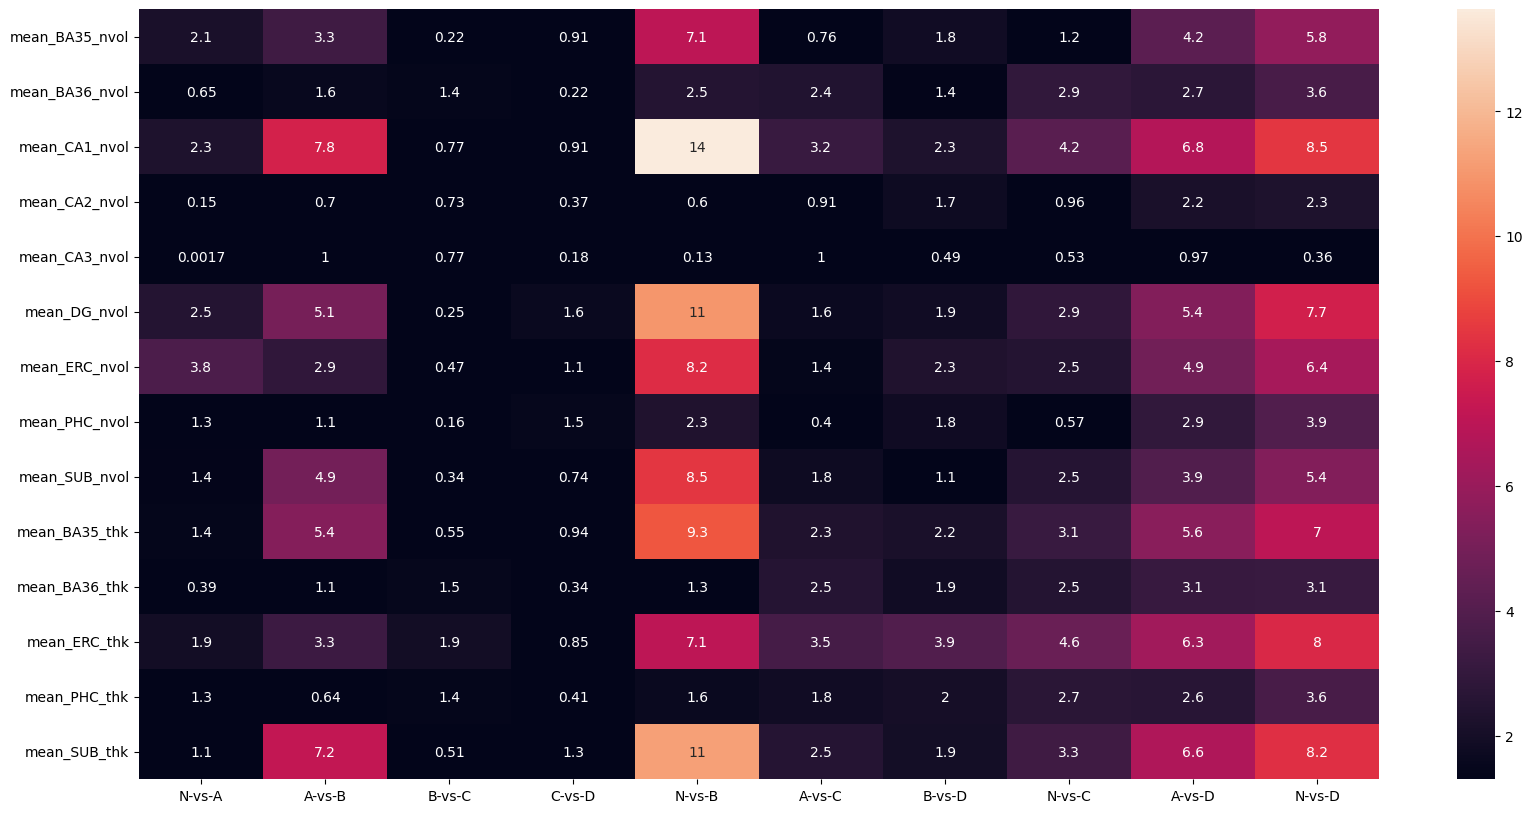

In [315]:
plt.figure(figsize=(20,10));
sns.heatmap(-np.log10(df_mwu), annot=True, vmin=-np.log10(0.05));

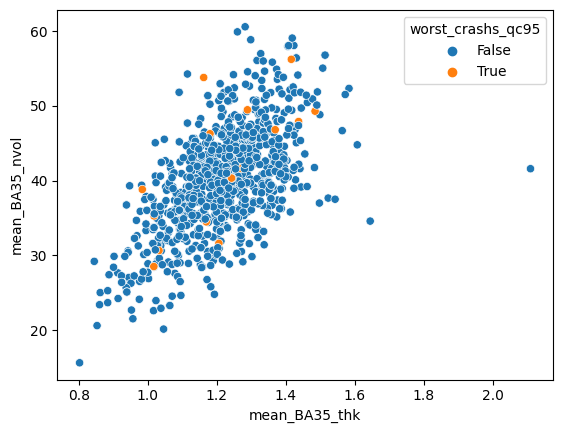

In [132]:
sns.scatterplot(data=df_test, x='mean_BA35_thk', y='mean_BA35_nvol', hue=df_test.worst_crashs_qc95 > 1.25);

In [133]:
# Generate a design matrix for Jack stage

In [134]:
x_glm = df_persubj_cleanthk[['ID','SMARTDATE','jack_at_stage','AGE']]
x_glm = x_glm.query('jack_at_stage != "I"').replace({'jack_at_stage':{'N':0, 'A':1, 'B':2, 'C':3, 'D':4}})
x_glm['intercept'] = 1.0
x_glm

,ID,SMARTDATE,jack_at_stage,AGE,intercept
1567,067_S_6529,2018-08-14,4,60.3,1.0
104,067_S_2304,2017-09-05,0,61.3,1.0
825,037_S_6046,2017-07-17,0,76.0,1.0
585,027_S_5093,2020-02-05,0,69.3,1.0
1079,168_S_6233,2018-02-26,1,76.4,1.0
...,...,...,...,...,...
597,027_S_5109,2017-08-03,1,78.4,1.0
1433,020_S_6449,2018-07-06,0,65.9,1.0
21,002_S_1261,2017-03-15,1,71.1,1.0
510,053_S_4813,2018-11-02,1,67.6,1.0


In [135]:
# Function to export all we need for a GLM analysis
def export_glm(data, fn_prefix, contrast_coding):
    data = data.dropna()
    os.makedirs(os.path.dirname(fn_prefix), exist_ok=True)
    def process_contrast(i, c, design_df, contrast_df):
        if c is None:
            return
        if isinstance(c, int) or isinstance(c, float):
            design_df[data.columns[i]] = data.iloc[:,i]
            contrast_df[data.columns[i]] = [c]
        elif isinstance(c, dict):
            for k, c_val in c.items():
                design_df[f'{data.columns[i]}:{k}'] = np.where(data.iloc[:,i] == k, 1, 0)
                contrast_df[f'{data.columns[i]}:{k}'] = [c_val]

    design_df = {}
    for name, row in contrast_coding.items():
        contrast_df = {}
        for i, c in enumerate(row):
            process_contrast(i, c, design_df, contrast_df)
        pd.DataFrame(contrast_df).to_csv(f'{fn_prefix}_contrast_{name}.txt', index=False, header=False, sep=' ')

    pd.DataFrame(design_df).to_csv(f'{fn_prefix}_design.txt', index=False, header=False, sep=' ')
    data.to_csv(f'{fn_prefix}.csv', index=False)

q_glm = x_glm[['ID','SMARTDATE','jack_at_stage','AGE','intercept']]
export_glm(q_glm, '../stats/glms/glm_jack_stage_linear/glm_jack_stage_linear', {
    'abstage':    [None,None,-1,0,0],
    'age':        [None,None,0,-1,0]
})

In [136]:
export_glm(q_glm, '../stats/glms/glm_jack_stage_cat/glm_jack_stage_cat', {
    'na':         [None,None,{0:1, 1:-1, 2:0, 3:0, 4:0}, 0, None],
    'ab':         [None,None,{0:0, 1:1, 2:-1, 3:0, 4:0}, 0, None],
    'bc':         [None,None,{0:0, 1:0, 2:1, 3:-1, 4:0}, 0, None],
    'cd':         [None,None,{0:0, 1:0, 2:0, 3:1, 4:-1}, 0, None],
    'nb':         [None,None,{0:1, 1:0, 2:-1, 3:0, 4:0}, 0, None],
    'nc':         [None,None,{0:1, 1:0, 2:0, 3:-1, 4:0}, 0, None],
    'nd':         [None,None,{0:1, 1:0, 2:0, 3:0, 4:-1}, 0, None]
})